In [50]:
push!(LOAD_PATH, pwd())
using SIS,IM,PayloadGraph,PyPlot, Epidemics,JLD, TwoLevelGraphs
import LightGraphs

function get_c_r(N,alpha,beta)
    return 4*alpha/(beta^2*N)
end

function get_n_n(N,alpha,beta)
    return beta/alpha*N
end

function get_alpha_beta(N,c_r,n_n)
    beta = 4.0/(c_r*n_n)
    alpha = (N*beta)/n_n
    return alpha,beta
end


f(y,alpha) = alpha.*y.^2
s(y,alpha,beta) = f(y,alpha)./y - beta
#get_y_eff(y,k) = y.*(1 + (1-y)./(y.*k))
#get_s_eff(y::Array,alpha,beta,k) = alpha*get_y_eff(y,k) - beta

function plot_schematic(n_n,c_r,N,k=N-1,plot_k=false)
    beta = 4.0/(c_r*n_n)
    alpha = (N*beta)/n_n
    y_n, y_minus,y_plus,y_p,critical_determinant = get_parameters(N,alpha,beta)



    y_range = collect(0:y_p/1000:1.9*y_p)
    figure(1)
    plot(y_range,1.0./abs(N*s(y_range,alpha,beta)),"-r",label=L"$\frac{1}{N|s(y)|}$")
    if plot_k
        plot(y_range,1.0./abs(N*get_s_eff(y_range,alpha,beta,k)),"-b",label=L"$\frac{1}{N|s(y_{eff})|}$")
    end
    plot(y_range,y_range,"-k",label=L"$y$")
    axvline(y_n,linestyle="--",label=L"$y_n$")
    axvline(y_p,linestyle="-",label=L"$y_p$")
    if y_minus > 0
        axvline(y_minus,linestyle="-.",label=L"$y_1$")
        axvline(y_plus,linestyle="-.",label=L"$y_2$")
    end
    ylim([0,1.9*y_p])
    legend(prop=Dict{Any,Any}("size"=>15),loc="upper right")
    xlabel(L"$y$",size=20)
    if plot_k
        #figure(1)
        #plot(y_range,get_s_eff(y_range,alpha,beta,k),"-b",label=L"$s_{eff}(y)$")
        #plot(y_range,s(y_range),"-r",label=L"$s(y)$")
        legend(prop=Dict{Any,Any}("size"=>20),loc="upper right")
        xlabel(L"$y$",size=20)
    end
end

function plot_schematics(N,alpha,beta,k,plot_k = false)
    im = InfectionModel(x -> 1 + alpha*x , x -> 1 + beta);
    imk = InfectionModel(x -> 1 + beta + get_s_eff(x,alpha,beta,k) , x -> 1 + beta);

    c_r = get_c_r(N,alpha,beta)
    n_n = get_n_n(N,alpha,beta)
    pygui(true)
    close(1);close(2);close(3)
    dx = 2*n_n/N/50
    x = collect(dx:dx:2*n_n/N)
    y = IM.P_fix(im,N,x)
    yk = IM.P_fix(imk,N,x)
    figure(2,figsize=(8,5))
    plot(x,y,"-r",label=L"P_{fix}(y)")
    plot(x,yk,"-b",label=L"P_{fix}(y_{eff})")
    plot(x,x,"--k")
    xlim([0,2*n_n/N])
    y_n, y_minus, y_plus, y_p,critical_determinant = get_parameters(N,alpha,beta)
    axvline(y_n,linestyle="--",color="b",label=L"y_n")
    axvline(y_minus,linestyle="-.",color="r",label=L"y_1")
    axvline(y_plus,linestyle="-.",color="r",label=L"y_2")
    axvline(y_p,linestyle="-",color="b",label=L"y_p")
    xlabel(L"y")
    ylabel(L"P_{fix}(y)")
    legend(loc="upper left")
    title(latexstring("\$y_n = $(n_n/N), c_r = $c_r, N = $N\$"))
    #savefig("p_fix_y_n = $(n_n/N), c_r = $c_r, N = $N.png")

    figure(1,figsize=(8,5))
    plot_schematic(n_n,c_r,N,k,plot_k)
    title(latexstring("\$y_n = $(n_n/N), c_r = $c_r, N = $N\$"))

    figure(3)
    plot(x,get_s_eff(x,alpha,beta,k),"-b",label=L"$s_{eff}(y)$")
    plot(x,s(x,alpha,beta),"-r",label=L"$s(y)$")
    grid()

end

function plot_w(sizes,N,alpha,beta)

    figure(4)
    bins = logspace(log10(minimum(sizes)),log10(maximum(sizes)),150)
    word = graph_model ? "graph" : "well-mixed"
    label = latexstring("$word, \$k = $k\$")
    PyPlot.plt[:hist](sizes,log=true,bins=bins,alpha=0.2,normed=true,label=label)

    gca()[:set_xscale]("log")

    w_range = bins[15:end]#logspace(log10(4*minimum(sizes)),log10(maximum(sizes)),30)

    P_w_th_range = normed_distribution(w_range,P_w_th(w_range,s(sqrt(w_range)./N,alpha,beta)))
    P_w_th_range_eff = normed_distribution(w_range,P_w_th(w_range,get_s_eff(sqrt(w_range)./N,alpha,beta,k)))
    
    if graph_model
        plot(w_range,P_w_th_range,"-r",label=L"theory $k \to N-1$")#$P(w) \sim e^{- s(\sqrt{w})^2 w/4} w^{-3/2}/(1 + s(\sqrt{w}))$ (theory)')
        plot(w_range,P_w_th_range_eff,"-g",label=latexstring("effective theory \$k = $k\$"))#$P(w) \sim e^{- s(\sqrt{w})^2 w/4} w^{-3/2}/(1 + s(\sqrt{w}))$ (theory)')
    end
        
    xlabel(L"$w$",size=20)
    ylabel(L"$P(w)$",size=20)

    legend(loc="lower left")
    ylim([1e-10,1e1])
    grid()

end

plot_w (generic function with 1 method)

In [2]:
data_dir_path = "../data/"  #"/mnt/D/windows/MIT/classes/6/338/project/data/"


"../data/"

In [5]:
Pkg.update()

INFO: Updating METADATA...
INFO: Computing changes...
INFO: No packages to install, update or remove


In [19]:
filenames = split(readall(`ls $data_dir_path`));
filenames[end-1:end]

2-element Array{SubString{ASCIIString},1}:
 "epidemics_2016-02-13T17:29:43.jld"
 "epidemics_2016-02-13T17:30:24.jld"

0.208 0.7804398162272768
Is graph model: true


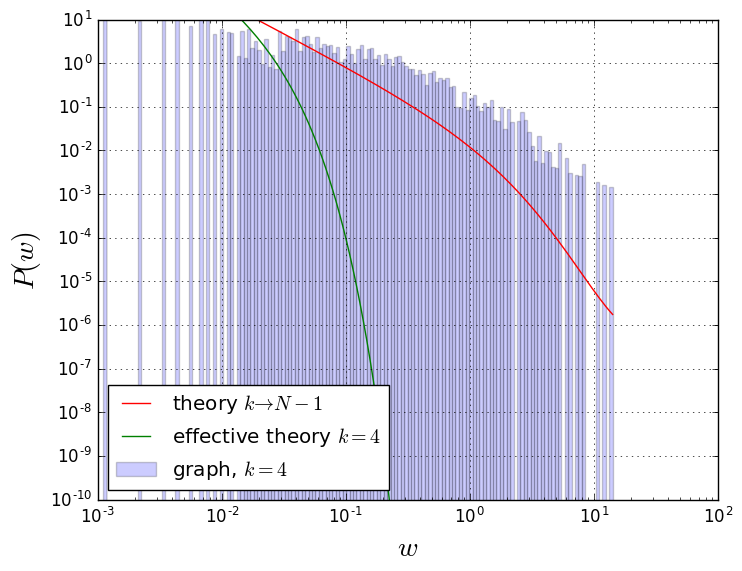

In [20]:
#using JLD
d = load(data_dir_path*filenames[end])
params = d["params"]
runs = d["runs"];
num_fixed = get_num_fixed(runs) #d["num_fixed"]
sizes = get_sizes(runs) #d["sizes"]

N = params["N"]
alpha = params["alpha"]
beta = params["beta"]
k = params["k"]
num_trials = length(runs)
graph_model = params["graph_model"]

c_r = get_c_r(N,alpha,beta)
n_n = get_n_n(N,alpha,beta)

#im = InfectionModel(x -> 1 + alpha*x , x -> 1 + beta);
im = InfectionModel(x -> 1 + beta + get_s_eff(x,alpha,beta,k) , x -> 1 + beta);

y_n, y_minus, y_plus, y_p,critical_determinant = get_parameters(N,alpha,beta)

#plot_schematics(N,alpha,beta,k,true)
plot_w(sizes,N,alpha,beta)

#im = InfectionModel(x -> 1 + alpha*x , x -> 1 + beta);

println(num_fixed/num_trials," ", IM.P_fix(im,N,1/N))

println("Is graph model: $graph_model")




In [103]:
runs = d["runs"];


In [106]:
#figure out which cluster the infecteds are in from the raw data
function get_infecteds_by_clusters_vs_time(clusters::Array{Array{Int,1},1},infecteds_by_nodes_vs_time::Array{Array{Int,1},1})
    infecteds_by_clusters_vs_time::Array{Array{Int,1},1} = []
    num_clusters = length(clusters)
    for infecteds_by_nodes in infecteds_by_nodes_vs_time
        infecteds_by_clusters = zeros(Int,num_clusters)
        for (i,clust) in enumerate(clusters)
            for node in clust
                if infecteds_by_nodes[node] == 1
                    infecteds_by_clusters[i] += 1
                end
            end
        end
        push!(infecteds_by_clusters_vs_time,infecteds_by_clusters)
    end
    return infecteds_by_clusters_vs_time
    
end

#we have infecteds vs. cluster idx and want to know how many clusters of infectivity level i there are for every possible i=1:m
function get_infection_distribution_over_clusters(t::TwoLevel,infecteds_by_clusters)
    assert(t.n == length(infecteds_by_clusters))
    infection_distribution = zeros(Int,t.m+1)
    for (i,num_infected) in enumerate(infecteds_by_clusters)
        infection_distribution[num_infected+1] += 1
    end
    return infection_distribution
end

function get_two_level_with_distribution(t_template::TwoLevel,infection_distribution::Array{Int,1})
    assert(t_template.m + 1 == length(infection_distribution))
    t = TwoLevel(t_template)
    t.a = infection_distribution
    make_consistent(t)
    return t
end

function get_two_level_states(tg::TwoLevelGraph,infecteds_by_nodes_vs_time::Array{Array{Int,1},1})
    two_level_states::Array{TwoLevel,1} = []
    infecteds_by_clusters_vs_time = get_infecteds_by_clusters_vs_time(tg.clusters,infecteds_by_nodes_vs_time)
    for infecteds_by_clusters in infecteds_by_clusters_vs_time
        push!(two_level_states,get_two_level_with_distribution(tg.t,get_infection_distribution_over_clusters(tg.t,infecteds_by_clusters)))
    end
    return two_level_states
end

function get_two_level_states_from_runs(runs::Array{EpidemicRun,1})
    tg_raw = runs[1].graph_information.data
    t_raw = runs[1].graph_information.data.t
    t::TwoLevel = TwoLevel(t_raw.a,t_raw.N,t_raw.m,t_raw.n,t_raw.i,t_raw.r,t_raw.l)
    tg::TwoLevelGraph = TwoLevelGraph(tg_raw.g,t,tg_raw.clusters)
    two_level_states::Array{TwoLevel,1} = []
    for run in runs
        two_level_states = vcat(two_level_states,get_two_level_states(tg,run.infecteds_by_nodes_vs_time))
    end
    return two_level_states
end


get_two_level_states_from_runs (generic function with 1 method)

In [107]:
# get all the TwoLevel representations for the runs
##TODO: need to group by i
two_level_states = get_two_level_states_from_runs(runs)

519735-element Array{TwoLevelGraphs.TwoLevel,1}:
 TwoLevelGraphs.TwoLevel([9,1,0,0,0,0,0,0,0,0  …  0,0,0,0,0,0,0,0,0,0],400,40,10,1,20,20) 
 TwoLevelGraphs.TwoLevel([9,1,0,0,0,0,0,0,0,0  …  0,0,0,0,0,0,0,0,0,0],400,40,10,1,20,20) 
 TwoLevelGraphs.TwoLevel([9,1,0,0,0,0,0,0,0,0  …  0,0,0,0,0,0,0,0,0,0],400,40,10,1,20,20) 
 TwoLevelGraphs.TwoLevel([9,1,0,0,0,0,0,0,0,0  …  0,0,0,0,0,0,0,0,0,0],400,40,10,1,20,20) 
 TwoLevelGraphs.TwoLevel([9,1,0,0,0,0,0,0,0,0  …  0,0,0,0,0,0,0,0,0,0],400,40,10,1,20,20) 
 TwoLevelGraphs.TwoLevel([9,1,0,0,0,0,0,0,0,0  …  0,0,0,0,0,0,0,0,0,0],400,40,10,1,20,20) 
 TwoLevelGraphs.TwoLevel([9,1,0,0,0,0,0,0,0,0  …  0,0,0,0,0,0,0,0,0,0],400,40,10,1,20,20) 
 TwoLevelGraphs.TwoLevel([9,1,0,0,0,0,0,0,0,0  …  0,0,0,0,0,0,0,0,0,0],400,40,10,1,20,20) 
 TwoLevelGraphs.TwoLevel([9,1,0,0,0,0,0,0,0,0  …  0,0,0,0,0,0,0,0,0,0],400,40,10,1,20,20) 
 TwoLevelGraphs.TwoLevel([9,1,0,0,0,0,0,0,0,0  …  0,0,0,0,0,0,0,0,0,0],400,40,10,1,20,20) 
 TwoLevelGraphs.TwoLevel([9,1,0,0,0,0,0,0

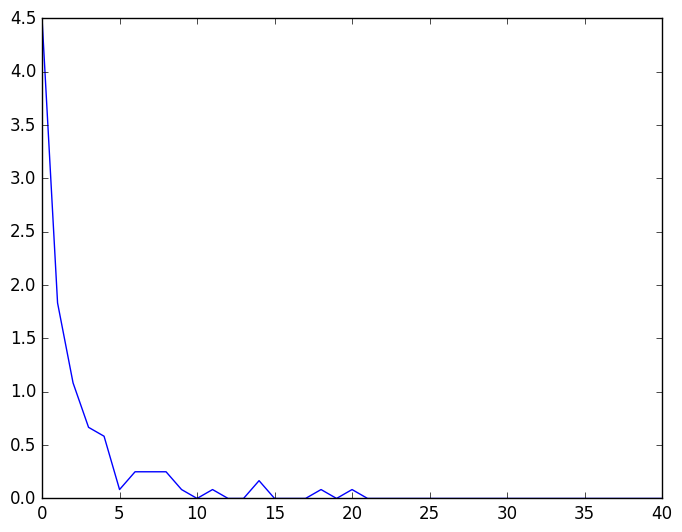

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x320e41090>

In [129]:
counter = 0
t = two_level_states[1]
accum = zeros(length(t.a))
for t in two_level_states
    if 0.05< t.i/t.N < 0.06
        counter += 1
        accum += t.a
    end
end
accum /= counter

plot(accum)

In [120]:
1+1 

2

In [ ]:
plot_schematics(N,alpha,beta,k,true)

In [ ]:
N = 1000
n_n = 400
c_r = 0.4
alpha,beta = get_alpha_beta(N,c_r,n_n)
plot_schematics(N,alpha,beta,k,true)
im = InfectionModel(x -> 1 + beta + get_s_eff(x,alpha,beta,k) , x -> 1 + beta);
IM.P_fix(im,N,1/N)

In [ ]:
alpha,beta

# why are there zero fixed for the graph case?

In [ ]:
plot_w(sizes,N,alpha,beta)

In [ ]:
get_s_eff


In [42]:
LightGraphs.Graph()

empty undirected graph